In [29]:
import pandas as pd

In [30]:
bioclimatic_data = pd.read_csv('PA-train-bioclimatic.csv')
merged_data = pd.read_csv('cluster_with_pollution_data.csv')

In [31]:
print(bioclimatic_data.columns)

Index(['surveyId', 'Bio1', 'Bio2', 'Bio3', 'Bio4', 'Bio5', 'Bio6', 'Bio7',
       'Bio8', 'Bio9', 'Bio10', 'Bio11', 'Bio12', 'Bio13', 'Bio14', 'Bio15',
       'Bio16', 'Bio17', 'Bio18', 'Bio19'],
      dtype='object')


# Particle Swarm Optimization

Selected species IDs: [6874]
Stopping search: maximum iterations reached --> 100
Recommended Cluster: 4044, Score: 1e+100


C:\Users\anagh\AppData\Local\Temp\ipykernel_24040\243806986.py:42: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return int(best_cluster), float(best_score)  # Return as scalar values


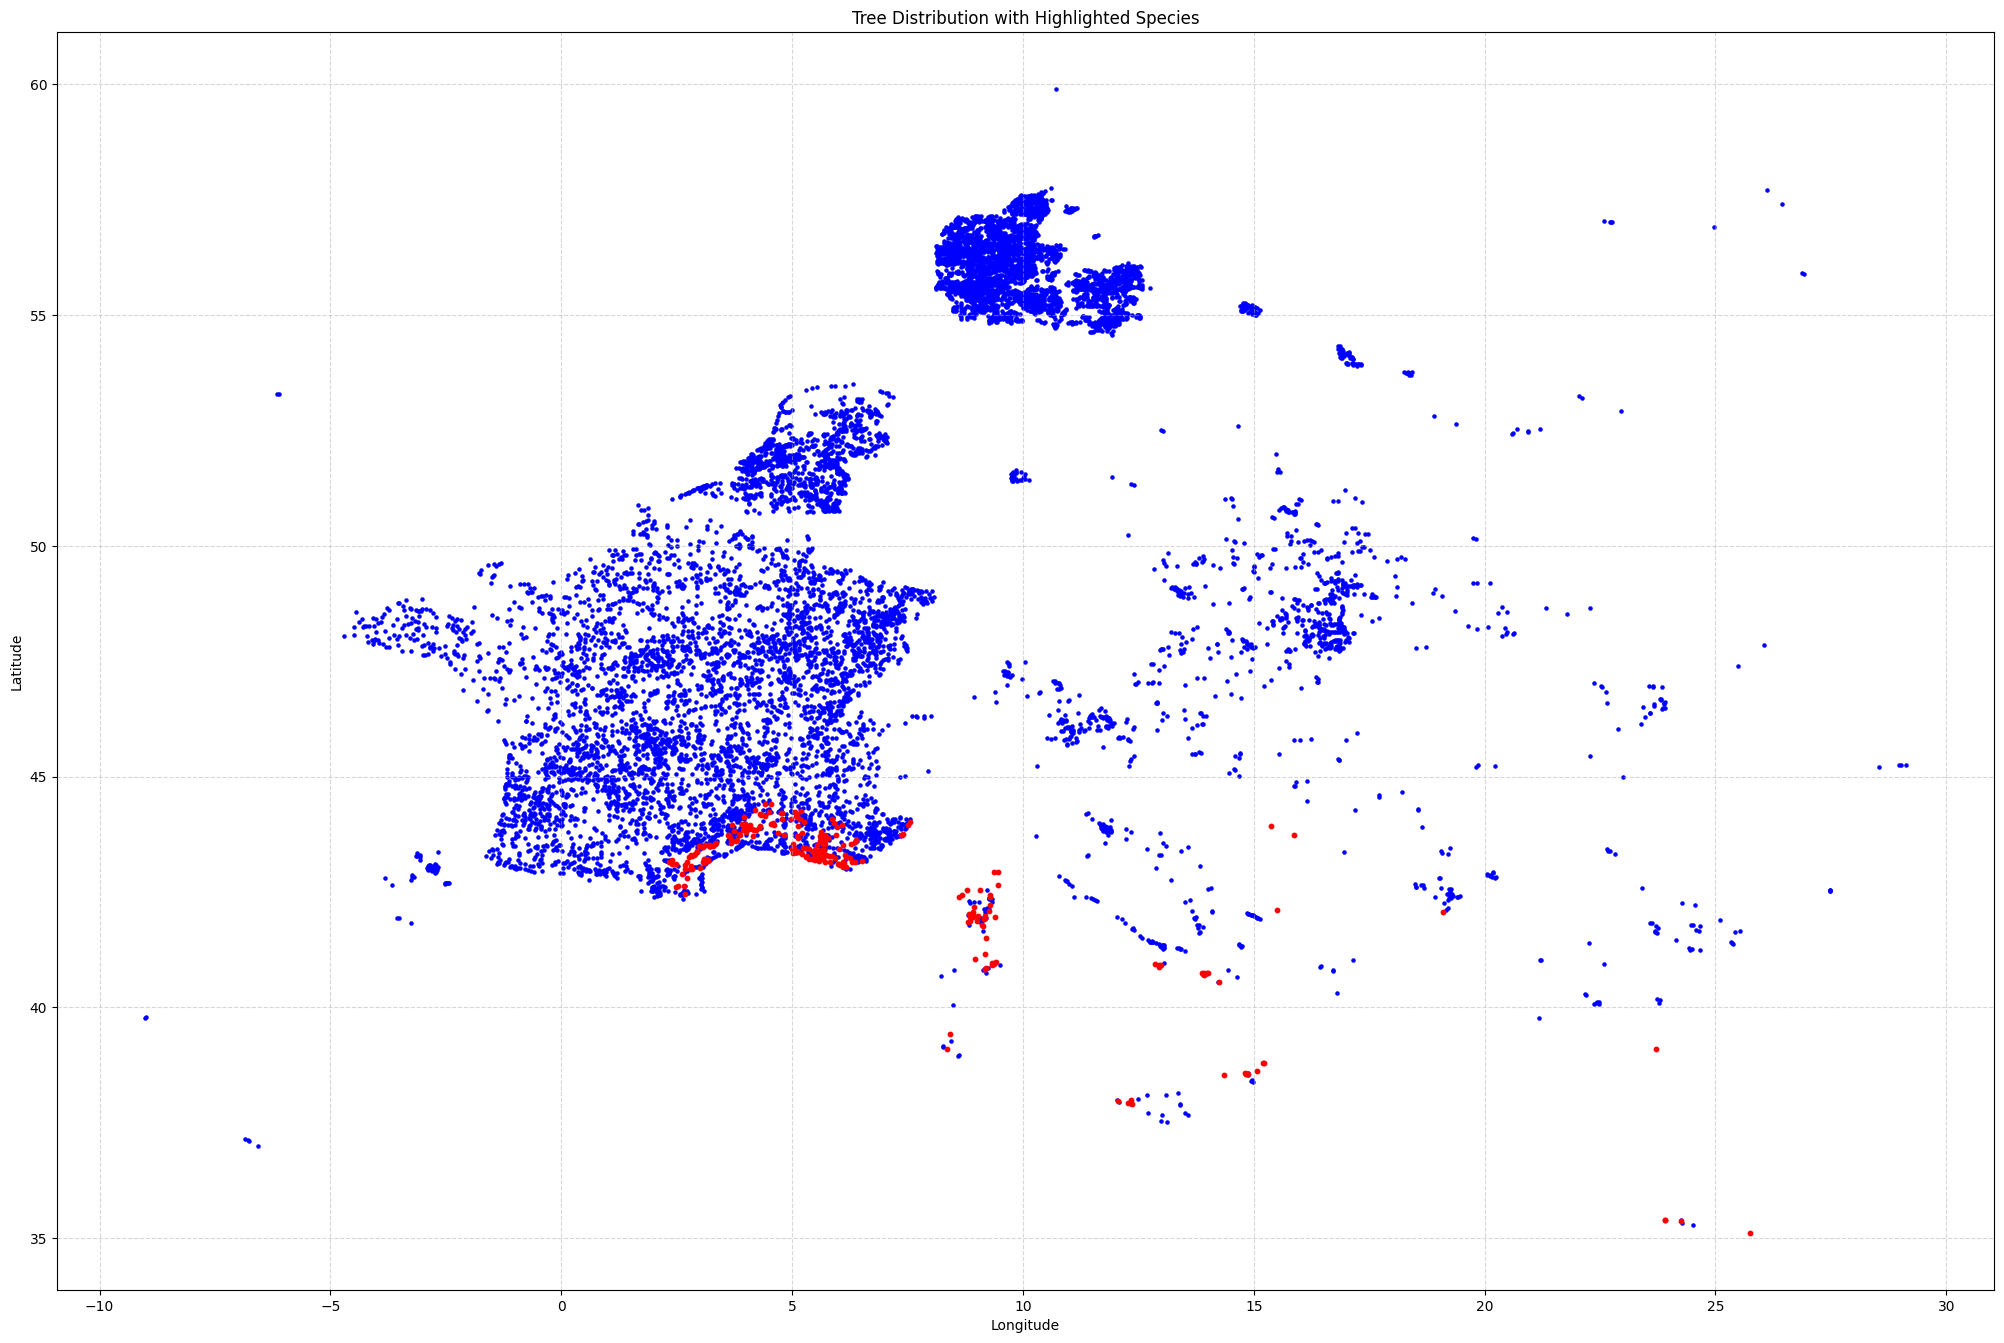

lat:19, lon:19


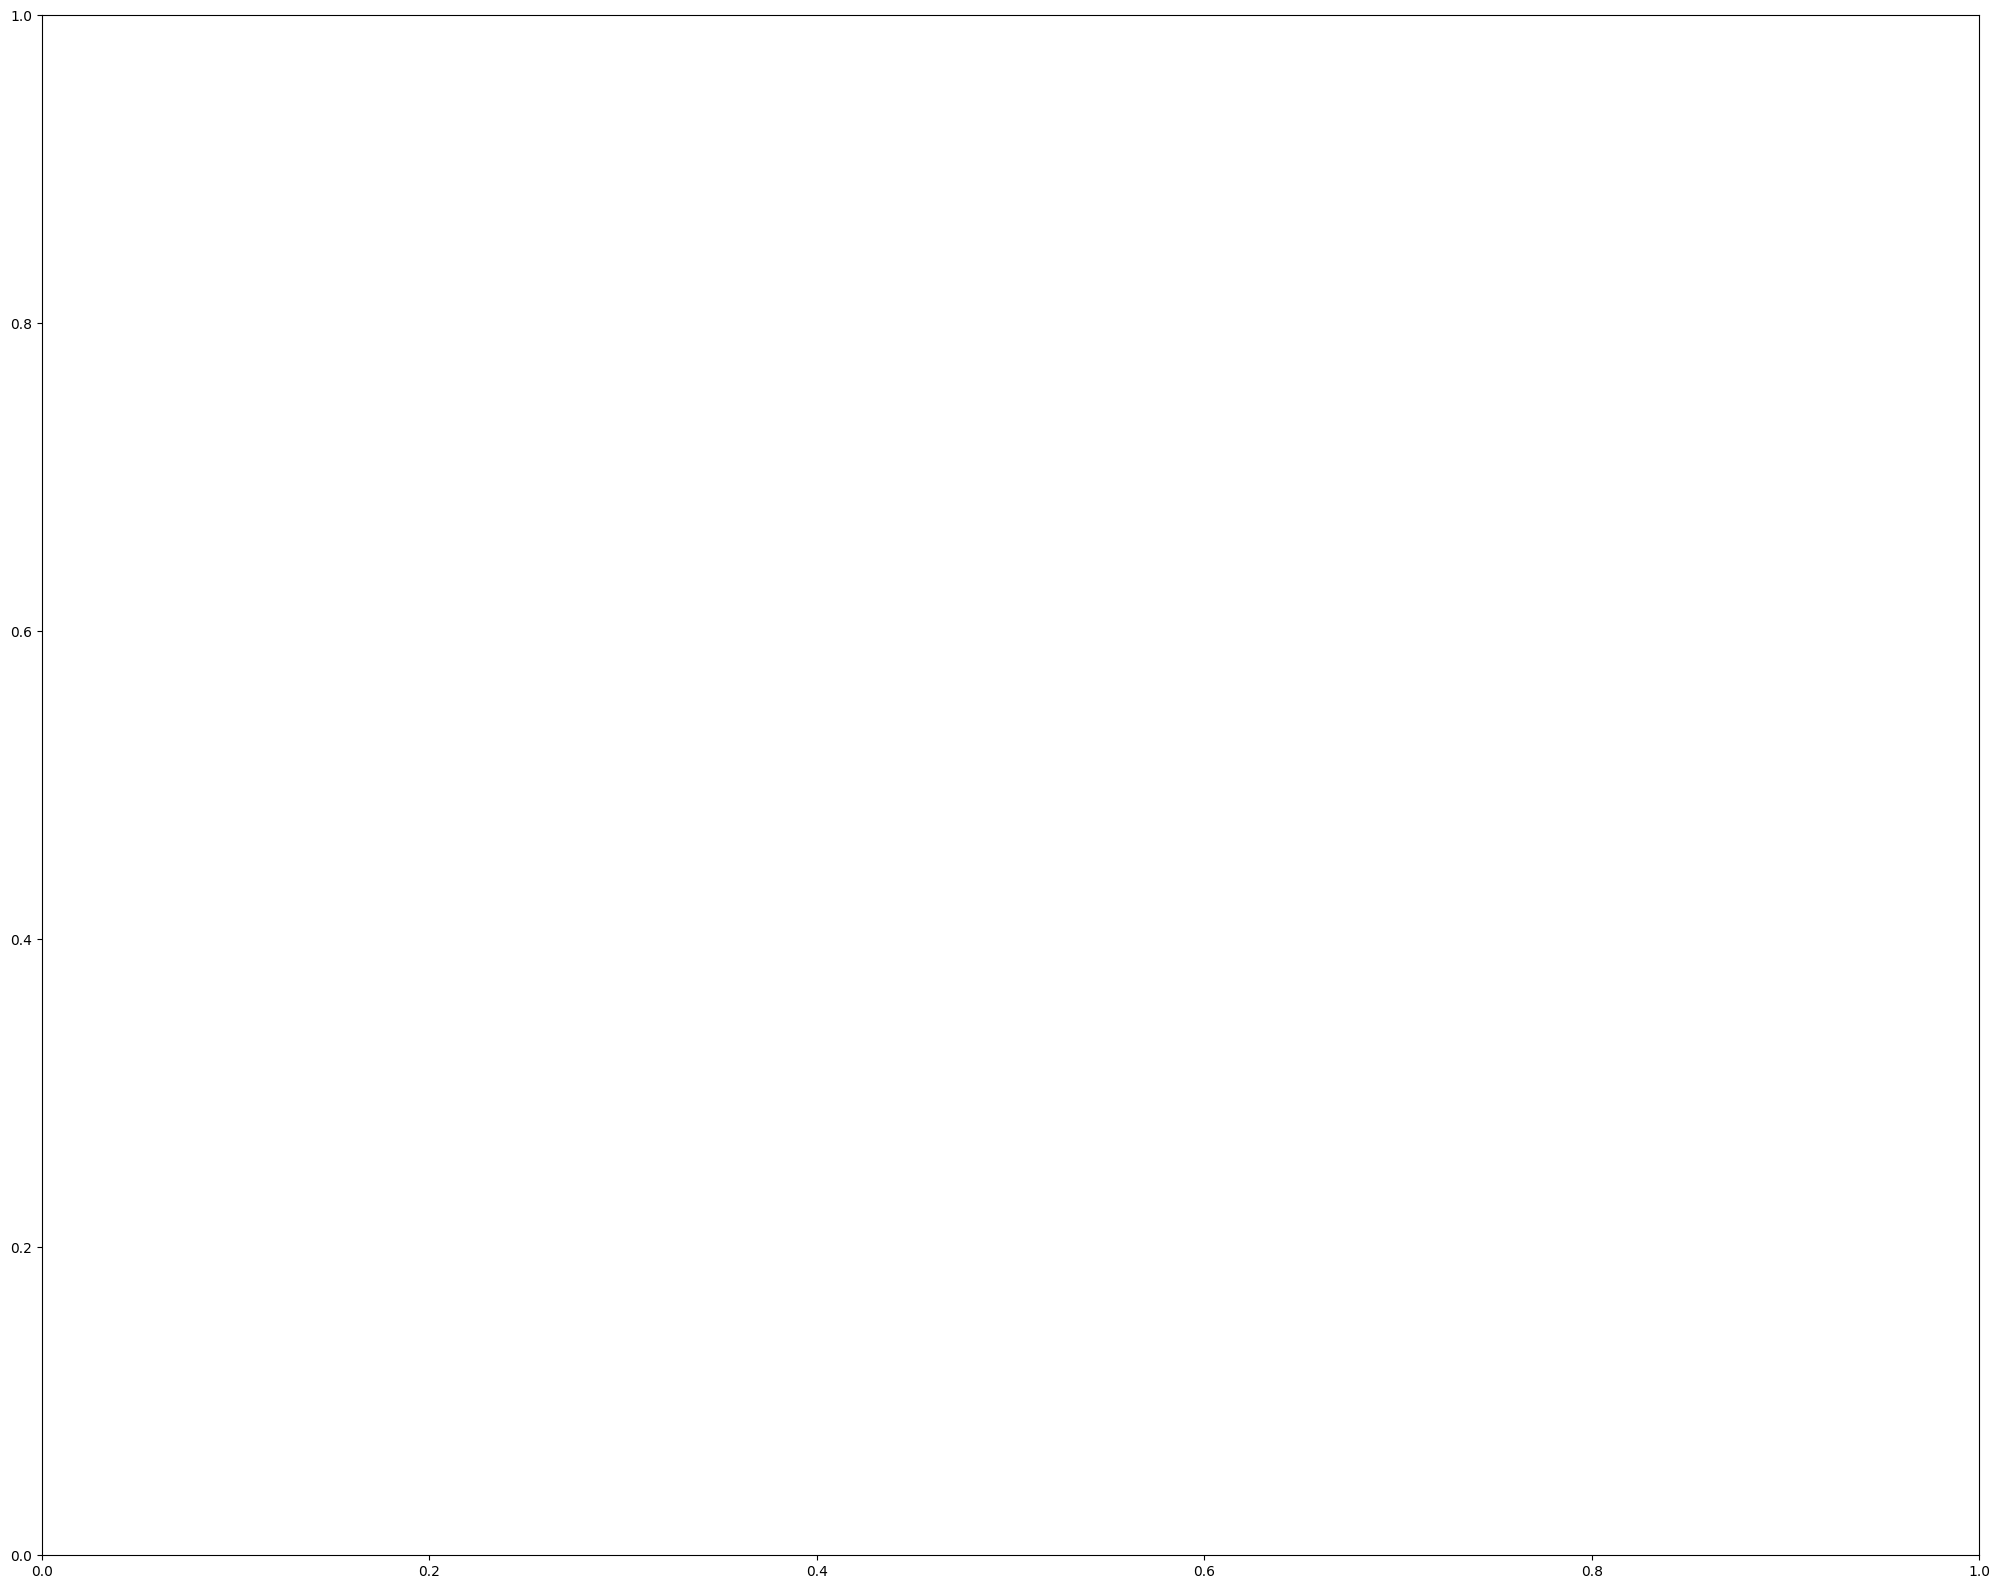

In [35]:
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
from pyswarm import pso
import random
from scipy.spatial import ConvexHull

# Set random seed for reproducibility
random.seed(42)
np.random.seed(42)

# Define a function to calculate the fitness of a cluster
def fitness_function(cluster, merged_data, bioclimatic_data):
    # Extract relevant pollution data for the cluster
    cluster_data = merged_data[merged_data['cluster'] == cluster]
    
    # Calculate a score based on AQI and other pollutants (lower is better)
    score = 0
    if not cluster_data.empty:
        score += cluster_data['AQI'].mean() * 0.4  # Weight for AQI
        score += cluster_data['CO'].mean() * 0.2   # Weight for CO
        score += cluster_data['NO2'].mean() * 0.2  # Weight for NO2
        score += cluster_data['PM2.5'].mean() * 0.2 # Weight for PM2.5
        
        # Add bioclimatic variable (e.g., Bio1)
        survey_id = cluster_data['surveyId'].values[0]  # Get the surveyId from the first entry
        bio1_mean = bioclimatic_data[bioclimatic_data['surveyId'] == survey_id]['Bio1'].mean()
        score += bio1_mean * 0.1  # Weight for Bio1
    
    return score

# PSO function to optimize cluster selection
def optimize_clusters(merged_data, bioclimatic_data):
    lb = [0]  # Lower boundary
    ub = [merged_data['cluster'].nunique() - 1]  # Upper boundary

    def objective_function(x):
        return fitness_function(int(x[0]), merged_data, bioclimatic_data)

    best_cluster, best_score = pso(objective_function, lb, ub)

    return int(best_cluster), float(best_score)  # Return as scalar values

# Function to plot the dataset with highlighted species ID and convex hull around recommended cluster
def plot_species_distribution(merged_data, species_ids, recommended_cluster=None):
    # Create a GeoDataFrame from the merged data
    geometry = gpd.points_from_xy(merged_data['average_lon'], merged_data['average_lat'])
    gdf = gpd.GeoDataFrame(merged_data, geometry=geometry)

    # Set up the plot
    fig, ax = plt.subplots(figsize=(25, 20))

    # Plot all points with a single marker
    gdf.plot(ax=ax, marker='o', color='blue', markersize=5)  # Use 'o' marker in blue color

    # Highlight specified species IDs in red
    for species_id in species_ids:
        highlighted_points = gdf[gdf['speciesId'].apply(lambda x: species_id in eval(x))]
        highlighted_points.plot(ax=ax, marker='o', color='red', markersize=10)  # Use 'o' marker in red color

    # Draw convex hull around recommended cluster if specified
    if recommended_cluster is not None:
        hull_points = gdf[gdf['cluster'] == recommended_cluster].geometry.apply(lambda geom: (geom.x, geom.y)).tolist()
        
        if len(hull_points) >= 3:  # Convex hull requires at least three points
            hull = ConvexHull(hull_points)
            for simplex in hull.simplices:
                plt.plot([hull_points[simplex[0]][0], hull_points[simplex[1]][0]], 
                         [hull_points[simplex[0]][1], hull_points[simplex[1]][1]], 'k-', lw=2)
            plt.scatter(*zip(*hull_points), color='orange', s=50)  # Plot hull points

    ax.grid(True, linestyle='--', alpha=0.5)  # Customize grid style and transparency

    plt.title("Tree Distribution with Highlighted Species")
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.show()

# Function to plot only the recommended cluster with all its coordinates
import ast  # To safely evaluate the string as a Python expression

def plot_recommended_cluster(merged_data, species_ids, recommended_cluster):
    # Filter the DataFrame for the recommended cluster
    cluster_data = merged_data[merged_data['cluster'] == recommended_cluster]

    # Set up the plot
    fig, ax = plt.subplots(figsize=(25, 20))

    # Plot all points in the cluster
    for index, row in cluster_data.iterrows():
        # Convert string representations of lists into actual lists
        lon_list = np.array(eval(row['coordinates_lon']))
        lat_list = np.array(eval(row['coordinates_lat']))

        # Check if lengths match
        if len(lon_list) != len(lat_list):
            print(f"Warning: Mismatched lengths for cluster {recommended_cluster} at index {index}.")
            continue  # Skip this row if lengths do not match
        else:
            print(f"lat:{len(lat_list)}, lon:{len(lon_list)}")

# Main function to run the optimization process and plotting
def main(merged_data, bioclimatic_data):
    user_input = input("Enter species IDs separated by commas: ")
    species_ids = [int(id.strip()) for id in user_input.split(',')]
    
    print(f"Selected species IDs: {species_ids}")

    # Optimize clusters based on selected species (currently not filtering by species; you can add this logic)
    recommended_cluster, score = optimize_clusters(merged_data, bioclimatic_data)
    
    print(f"Recommended Cluster: {recommended_cluster}, Score: {score}")

    # Plot distribution with highlighted species IDs and convex hull around the recommended cluster
    plot_species_distribution(merged_data, species_ids, recommended_cluster)

    # Plot only the recommended cluster with all its coordinates
    plot_recommended_cluster(merged_data, species_ids, recommended_cluster)

# Example usage with your existing dataframes (replace with your actual data)
if __name__ == "__main__":
    main(merged_data, bioclimatic_data)